# Miniproject
Create a personalized sound level meter that takes into account the loudness sensitivity of your own ears.
1. program that generates a test tone and that allows you to interactively change the volume of the test tone;
2. perform a series of listening tests with your program to determine your typical ear sensitivity curve;
3. use the values in the curve to design a simple **weighting filter**;
4. use the weighting filter to compute the perceptual loudness of an audio file.

#### A little of theory
The Sound Pressure Level (SPL) $L_p$ is defined as function of smallest sound pressure detected by human ear: $p_0=20 \cdot 10^{-6}$. $L_p=20\cdot\log_{10}\frac{p}{p_0}.$

$p$ is determined as the root-mean-square (RMS) of a sequence of $n$ measurements of the sound pressure: $p=\sqrt{\frac{1}{n}(x_1^2+x_2^2+...+x_n^2)}$.

A common unit of subjective loudness is the phon; an increase of 10 units on the phon scale corresponds to doubling the perceived loudness of the sound.

## 1. Psychoacoustic Experiment

A program with a simple interface that allows the user to play either the reference tone at 1 kHz or the test tone at another random frequency in the 20 Hz to 15 kHz range; the user interface needs to provide a way to adjust the volume of the test tone and to store the volume value once the user finalizes their selection.

40 phon equal-loudness curve

In [155]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import sounddevice as sd
import ipywidgets as widgets
from IPython.display import Audio, display
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output

figsize=(10,5)
linewidth=2.5
matplotlib.rcParams.update({'font.size': 16})

# Constants
fs = 44100
time = np.linspace(0, 2, 2*fs)
samples = np.arange(2*fs)
fourier = np.linspace(0, .2*np.pi, 2*fs)

def sine(A, f, phi, n):
    return A * np.sin(2*np.pi*f*n - phi)
def play_tone(volume, frequency):
    assert(volume >= 0 and volume <= 100)
    tone = sine(A=volume/100, f=frequency, phi=0, n=time)
    sd.play(tone, fs)
def f(x):
    return x

In [128]:
# Pre-define frequencies that the user will define loudness for
N = 16
nr_values_per_octave = 2
test_frequencies = np.empty((N,))
for i in range(N):
    test_frequencies[i] = 60 * np.power(2, i/nr_values_per_octave)
test_frequencies = [int(el) for el in test_frequencies]
test_frequencies

[60,
 84,
 120,
 169,
 240,
 339,
 480,
 678,
 960,
 1357,
 1920,
 2715,
 3840,
 5430,
 7680,
 10861]

In [130]:
# Reference tune play-button
button = widgets.Button(description="Play reference")
output = widgets.Output()
display(button, output)

# Put the computer volume at 50
ref_frequency = 1_000
ref_volume = 50

def on_ref_button_clicked(b):
    with output:
        play_tone(volume=ref_volume, frequency=ref_frequency)
button.on_click(on_ref_button_clicked)

Button(description='Play reference', style=ButtonStyle())

Output()

In [131]:
# Initialize dictionary that will hold volumes
equal_loudness_curve = dict.fromkeys(test_frequencies, None)

# List of frequencies
print(f'Select the frequency for which to choose the volume')
chosen_frequency = interactive(f, x=test_frequencies)
display(chosen_frequency)

# Test tune play-button
button = widgets.Button(description="Play test")
output = widgets.Output()
display(button, output)
def on_test_button_clicked(b):
    with output:
        play_tone(volume=volume.result, frequency=chosen_frequency.result)
        equal_loudness_curve[chosen_frequency.result] = volume.result
        clear_output(wait=False)
        print(equal_loudness_curve)
        
button.on_click(on_test_button_clicked)

# Test tune volume
volume = interactive(f, x=widgets.IntSlider(min=0, max=100, step=1, value=30))
display(volume)

Select the frequency for which to choose the volume


interactive(children=(Dropdown(description='x', options=(60, 84, 120, 169, 240, 339, 480, 678, 960, 1357, 1920…

Button(description='Play test', style=ButtonStyle())

Output()

interactive(children=(IntSlider(value=30, description='x'), Output()), _dom_classes=('widget-interact',))

In [158]:
# Save button - save dictionary to json file

########
your_name = 'MATHEUS' #'MATHEUS' # 'HUSSAM', 'THOMAS'
########

button = widgets.Button(description="Save volume")
output = widgets.Output()
display(button, output)
def on_save_button_clicked(b):
    with output:
        if sum([volume == None for volume in equal_loudness_curve]):
            clear_output(wait=False)
            print('You forget to set the volume of a frequency.')
        else:
            clear_output(wait=False)
            with open(f'equal_loudness_curve_{your_name}.json', 'w') as fp:
                json.dump(equal_loudness_curve, fp)
            print(f'Saved to equal_loudness_curve_{your_name}.json.')
button.on_click(on_save_button_clicked)

Button(description='Save volume', style=ButtonStyle())

Output()

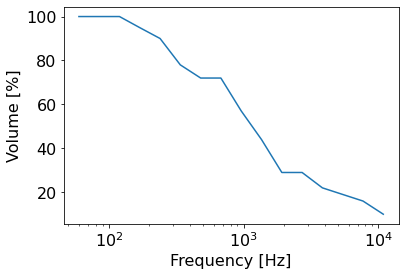

In [149]:
plt.plot(list(equal_loudness_curve.keys()),list(equal_loudness_curve.values())) 
plt.xlabel('Frequency [Hz]')
plt.ylabel('Volume [%]')
plt.xscale('log')

## 2. Weighting filter
At this point your equal-loudness contour data will be a set of frequency-volume pairs $(f_n, v_n)_n$. In order to obtain a weighting filter, you need to design a digital filter that approximates the inverse of the contour. The simplest way is to design an FIR whose magnitude response interpolates the points $(f_n , \frac{1}{v_n})_n$. To achieve this, you can for instance look at the documentation for the routines [scipy.signal.firwin2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin2.html) and [scipy.signal.firls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html) in SciPy.

In [211]:
from scipy.signal import firwin2, freqz 

with open('equal_loudness_curve_MATHEUS.json') as fb:
    curve = json.load(fb)
frequencies = np.array(['0'] + list(curve.keys()), dtype=np.float32) # add a 0 in the beginning as it is required by firwin2 that frequency start with 0 (and end with fs)
gains = 1 / np.array(list(curve.values()))
gains = np.insert(gains, 0, 0)
fs = frequencies[-1] * 2
fir_coefficients = scipy.signal.firwin2(numtaps=11, freq=frequencies, gain=gains, fs=fs)
fir_coefficients

array([-1.28603967e-04, -1.36894744e-05, -1.79036809e-03,  9.27530407e-05,
       -1.47406267e-02,  5.25727329e-02, -1.47406267e-02,  9.27530407e-05,
       -1.79036809e-03, -1.36894744e-05, -1.28603967e-04])

Now, plot the frequency response given the coefficients of the FIR filter. Here is a website I got inspiration from: https://scipy-cookbook.readthedocs.io/items/FIRFilter.html.

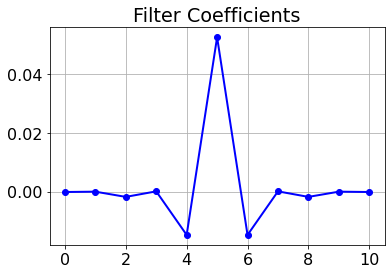

In [215]:
plt.plot(fir_coefficients, 'bo-', linewidth=2)
plt.title('Filter Coefficients')
plt.grid(True)

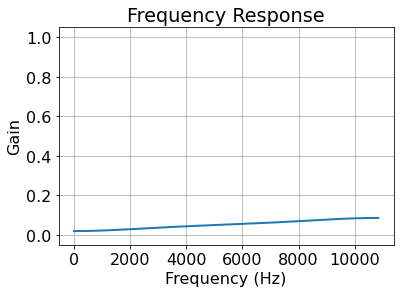

In [219]:
w, h = freqz(fir_coefficients)
plt.plot((w/np.pi) * fs/2, np.absolute(h), linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.ylim(-0.05, 1.05)
plt.grid(True)
# plt.xscale('log')

## 3. Sound meter
Finally, implement a sound meter that pre-processes the input via the weighting filter and then computes
the time-varying RMS via an averaging filter with user-definable range (either a moving average or a leaky
integrator). Compare the results obtained with pre-filtering to those without.


In [216]:
# Pre-filter audio file with weighting filter
# TODO

In [ ]:
# Compute RMS of an audio-file via an averaging filter
# TODO